In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import shap
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")

In [3]:
merged_cohort = pd.read_csv("merged_file.csv")
y = merged_cohort['Outcome_Occlusion_MI']
X = merged_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,  # 30% for val+test (which is 15%+15%)
    stratify=y,
    random_state=99
)
'''
# Step 2: Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 50% of 30% = 15% of original data
    stratify=y_temp,  # Maintain stratification in this split too
    random_state=99
)
'''
# Verify the proportions
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X):.1%})")
#print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X):.1%})")

Training set: 5850 samples (80.0%)
Validation set: 1463 samples (20.0%)


In [4]:
for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    #X_test[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
#y_test = np.ravel(np.array(y_test.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

C:\Users\arthu\AppData\Local\Temp\ipykernel_100248\1319206832.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_100248\1319206832.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [5]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'KNN (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [7]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

In [ ]:
# Define your parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [0, 1, 10]
}

# Run cross-validation hyperparameter tuning
best_model, best_params, cv_results = xgb_hyperparameter_tuning_cv(X_train, y_train, param_grid=param_grid)

# Print top 5 parameter combinations
print("\nTop 5 Parameter Combinations:")
for i, result in enumerate(cv_results[:5]):
    print(f"{i+1}. Mean AUROC: {result['mean_auroc']:.4f} ± {result['std_auroc']:.4f}")
    print(f"   Parameters: {result['params']}")

Hyperparameter Tuning with 10-fold Cross-Validation
Searching through 2187 parameter combinations...

Parameter combination 1/2187:
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0, 'reg_lambda': 0}
  Fold 1/10 - AUROC: 0.7959
  Fold 2/10 - AUROC: 0.8572
  Fold 3/10 - AUROC: 0.9022
  Fold 4/10 - AUROC: 0.8210
  Fold 5/10 - AUROC: 0.8644
  Fold 6/10 - AUROC: 0.8664
  Fold 7/10 - AUROC: 0.8677
  Fold 8/10 - AUROC: 0.8780
  Fold 9/10 - AUROC: 0.8481
  Fold 10/10 - AUROC: 0.8849
  Mean AUROC: 0.8586 ± 0.0293

Parameter combination 2/2187:
Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0, 'reg_lambda': 1}
  Fold 1/10 - AUROC: 0.7910
  Fold 2/10 - AUROC: 0.8546
  Fold 3/10 - AUROC: 0.8900
  Fold 4/10 - AUROC: 0.8218
  Fold 5/10 - AUROC: 0.8638
  Fold 6/10 - AUROC: 0.8603
  Fold 7/10 - AUROC: 0.8684
  Fold 8/10 - AUROC: 0.8766
  Fold 9/10 - 

In [13]:
# Print the best parameters for XGBoost
print("Best XGBoost Parameters:")
print(best_params)

# Or print individual parameters
print(f"Learning rate: {best_params['learning_rate']}")
print(f"Subsample: {best_params['subsample']}")
print(f"Colsample bytree: {best_params['colsample_bytree']}")
print(f"Reg alpha: {best_params['reg_alpha']}")
print(f"Reg lambda: {best_params['reg_lambda']}")

Best XGBoost Parameters:
{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.7, 'reg_alpha': 0, 'reg_lambda': 0}
Learning rate: 0.1
Subsample: 0.8
Colsample bytree: 0.7
Reg alpha: 0
Reg lambda: 0


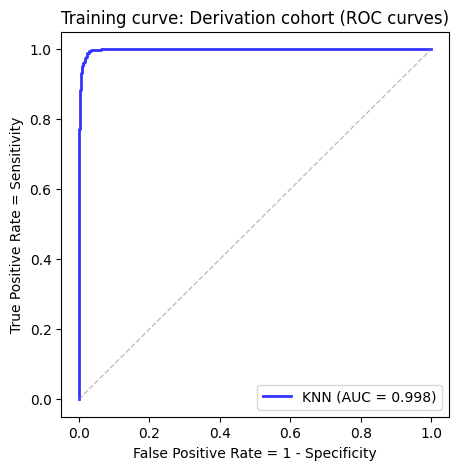

Training AUROC: 0.998 (95% CI: 0.997, 0.999)


In [19]:
# 1. Train the best model on the entire training set
best_xgb = XGBClassifier(
    n_estimators=180,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0,
    reg_lambda=0,
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)

# Fit the model on the entire training set
best_xgb.fit(X_train, y_train)

# 2. Predict on training data
pred_probas_train = best_xgb.predict_proba(X_train)

# 3. Compute ROC curve and area under the curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)

# 4. Plot ROC curve
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# 5. Compute AUROC CI using bootstrap
auroc_ci_lower_train, auroc_ci_upper_train = bootstrap_metric_ci(y_train, pred_probas_train[:,1], "auroc")
print(f"Training AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_train:.3f}, {auroc_ci_upper_train:.3f})")

# 6. Save the model for future use
import pickle
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)


Validation Set Evaluation:


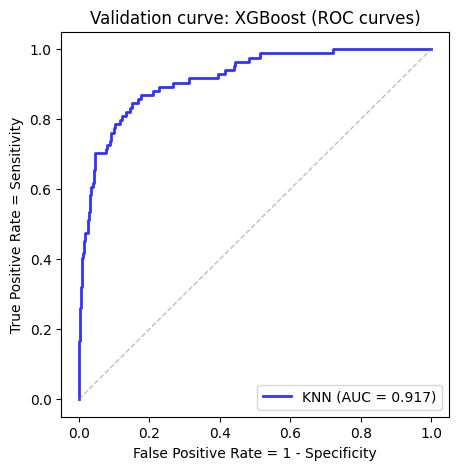

Validation AUROC: 0.917 (95% CI: 0.884, 0.945)


In [20]:
# Evaluate XGBoost model on validation set
print("\nValidation Set Evaluation:")
pred_probas_val = best_model.predict_proba(X_val)

# Compute ROC curve and area under the curve for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, pred_probas_val[:,1])
roc_auc_val = auc(fpr_val, tpr_val)

# Plot the ROC curve
plot_ROC_curve(fpr_val, tpr_val, roc_auc_val, 'Validation curve: XGBoost (ROC curves)')

# Compute AUROC CI using bootstrap
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

# Print results
print(f"Validation AUROC: {roc_auc_val:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")


Val


NameError: name 'X_test' is not defined